<a href="https://colab.research.google.com/github/hardik-xi11/btpm/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ==========================================
# 1. ENVIRONMENT SETUP & KAGGLE API
# ==========================================
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

key_file_path = '/content/kaggle_token.txt'

with open(key_file_path, 'r') as file:
    # .strip() removes any accidental newlines or spaces
    token = file.read().strip()

# 3. Set the environment variables
os.environ['KAGGLE_KEY'] = token

os.environ['KAGGLE_USERNAME'] = "xihardik05"

print(token)

print("✅ Kaggle key loaded successfully.")

print("✅ Kaggle API setup complete.")

KGAT_d64570b7c4da89655758f4c2265328e2
✅ Kaggle key loaded successfully.
✅ Kaggle API setup complete.


In [5]:
# ==========================================
# 2. DATASET DOWNLOAD
# ==========================================
print("⏳ Downloading Dataset...")
# Downloading Masoud Nickparvar's Brain Tumor MRI Dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

print("⏳ Unzipping Dataset...")
!unzip -q brain-tumor-mri-dataset.zip -d raw_data
print("✅ Dataset Downloaded & Unzipped.")


⏳ Downloading Dataset...
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 91% 135M/149M [00:00<00:00, 1.40GB/s]
100% 149M/149M [00:00<00:00, 1.32GB/s]
⏳ Unzipping Dataset...
✅ Dataset Downloaded & Unzipped.


In [6]:
# ==========================================
# 3. ROBUST DATA SPLITTING (The "Fix")
# ==========================================
# We will combine all images and create a clean 70/15/15 split
# to avoid "empty test set" errors.

root_dir = 'raw_data' # Depending on unzip, this might need adjustment, but usually it extracts here
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
base_path = 'processed_dataset'

# Create new directory structure
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_path, split, cls), exist_ok=True)

# Define Split Ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print("🔄 Re-organizing dataset into Train/Val/Test...")

# Function to locate all images regardless of original folder structure
def get_all_file_paths(source_dir, class_name):
    file_paths = []
    # Walk through the raw_data folder to find files matching the class
    for root, dirs, files in os.walk(source_dir):
        # Check if the current folder name matches the class (case insensitive)
        if class_name.lower() in root.lower():
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_paths.append(os.path.join(root, file))
    return file_paths

total_images = 0

for cls in classes:
    # Gather all images for this class
    all_images = get_all_file_paths(root_dir, cls)
    random.shuffle(all_images)

    # Calculate split indices
    n = len(all_images)
    train_end = int(n * TRAIN_RATIO)
    val_end = train_end + int(n * VAL_RATIO)

    train_imgs = all_images[:train_end]
    val_imgs = all_images[train_end:val_end]
    test_imgs = all_images[val_end:]

    # Move files to new destination
    for img in train_imgs:
        shutil.copy(img, os.path.join(base_path, 'train', cls, os.path.basename(img)))
    for img in val_imgs:
        shutil.copy(img, os.path.join(base_path, 'val', cls, os.path.basename(img)))
    for img in test_imgs:
        shutil.copy(img, os.path.join(base_path, 'test', cls, os.path.basename(img)))

    print(f"   Mapped {cls}: {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")
    total_images += n

print(f"✅ Data Reorganization Complete. Total Images: {total_images}")



🔄 Re-organizing dataset into Train/Val/Test...
   Mapped glioma: 1134 Train, 243 Val, 244 Test
   Mapped meningioma: 1151 Train, 246 Val, 248 Test
   Mapped notumor: 1400 Train, 300 Val, 300 Test
   Mapped pituitary: 1229 Train, 263 Val, 265 Test
✅ Data Reorganization Complete. Total Images: 7023


In [7]:
# ==========================================
# 4. PREPROCESSING & AUGMENTATION
# ==========================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# augmentation for training (Helps with small datasets)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# NO augmentation for Validation/Test (Only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("⚙️ Setting up Data Generators...")

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



⚙️ Setting up Data Generators...
Found 4914 images belonging to 4 classes.
Found 1052 images belonging to 4 classes.
Found 1057 images belonging to 4 classes.


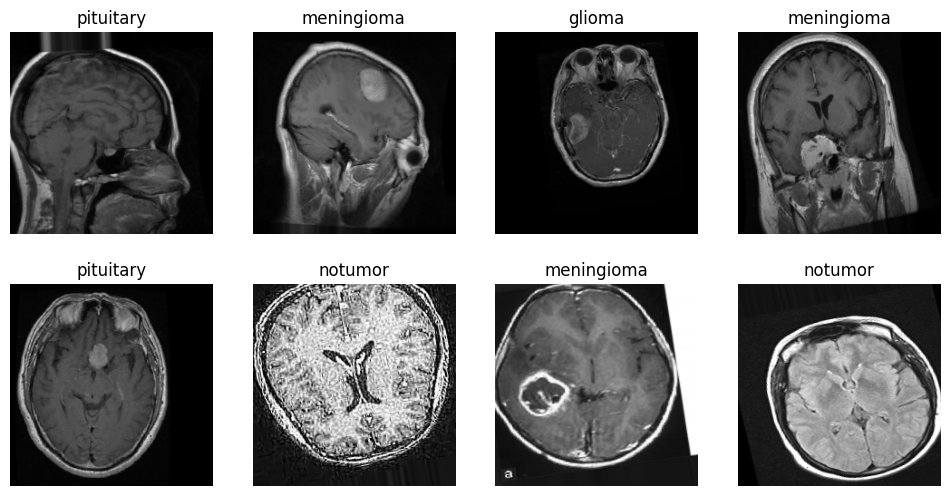

✅ Phase 1 & 2 Complete! Ready for Model Building.


In [8]:
# ==========================================
# 5. VISUALIZATION CHECK
# ==========================================
# Let's view a batch to make sure labels are correct
class_dict = {v: k for k, v in train_generator.class_indices.items()}

images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_dict[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

print("✅ Phase 1 & 2 Complete! Ready for Model Building.")

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
EPOCHS = 20  # You can increase this if early stopping doesn't kick in

# Create a directory to save the best models
os.makedirs('models', exist_ok=True)



In [10]:
# ==========================================
# 2. MODEL 1: OPTIMIZED CUSTOM CNN (The Baseline)
# ==========================================
def build_custom_cnn():
    model = Sequential([
        Input(shape=IMG_SHAPE),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Head (The "Fix" for 151M params -> GlobalAveragePooling)
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("🏗️ Building Custom CNN...")
cnn_model = build_custom_cnn()
cnn_model.summary()



🏗️ Building Custom CNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# ==========================================
# 3. MODEL 2: TRANSFER LEARNING (EfficientNetB0)
# ==========================================
def build_efficientnet():
    # Load pre-trained weights (ImageNet), exclude top layers
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

    # Freeze the base model (we don't want to destroy pre-learned patterns yet)
    base_model.trainable = False

    # Add new top layers for our specific 4 classes
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("🏗️ Building EfficientNetB0...")
eff_model = build_efficientnet()
# We skip summary for EfficientNet because it's huge, but it's loaded!



🏗️ Building EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# ==========================================
# 4. CALLBACKS (The Safety Net)
# ==========================================
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'models/{model_name}_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    return [checkpoint, early_stop, reduce_lr]



In [ ]:
# ==========================================
# 5. TRAINING EXECUTION
# ==========================================

print("\n🚀 STARTING TRAINING: Custom CNN")
history_cnn = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=get_callbacks('custom_cnn')
)
z1
print("\n🚀 STARTING TRAINING: EfficientNetB0")
history_eff = eff_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=get_callbacks('efficientnet')
)

print("\n✅ Phase 3 & 4 Complete! Models Trained and Saved.")



🚀 STARTING TRAINING: Custom CNN


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6167 - loss: 0.9384
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to models/custom_cnn_best.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 967s 6s/step - accuracy: 0.6170 - loss: 0.9377 - val_accuracy: 0.2500 - val_loss: 3.1195 - learning_rate: 0.0010
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7440 - loss: 0.6612
Epoch 2: val_accuracy improved from 0.25000 to 0.28327, saving model to models/custom_cnn_best.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 986s 6s/step - accuracy: 0.7440 - loss: 0.6610 - val_accuracy: 0.2833 - val_loss: 6.1545 - learning_rate: 0.0010
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7593 - loss: 0.5917
Epoch 3: val_accuracy improved from 0.28327 to 0.32700, saving model to models/custom_cnn_best.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 963s 6s/step - accuracy: 0.7594 - loss: 0.5915 - val_accuracy: 0.3270 - val_loss: 4.7587 - learning_rate: 0.0010
Epoch 4/20
154/154 